In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.isnull().sum().sum()

0

There are no missing or null values in any feature for any object.

In [5]:
df.duplicated().sum()

1081

Let's drop all the duplicate records for accurate analysis.

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Let's plot the histogram of transaction class and their count to check the balance of the dataset.

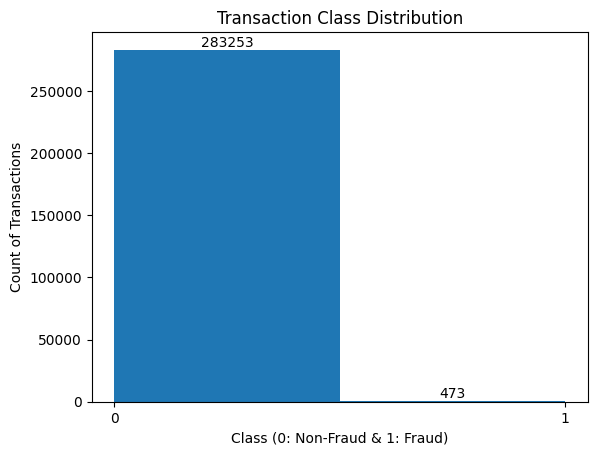

In [7]:
cnt, edge, bars = plt.hist(df['Class'].astype(str), bins=2)
plt.bar_label(bars)
plt.title('Transaction Class Distribution')
plt.xlabel('Class (0: Non-Fraud & 1: Fraud)')
plt.ylabel('Count of Transactions')
plt.show()

In [8]:
df.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,283253.0,88.413575,250.379023,0.0,5.67,22.00,77.46,25691.16
1,473.0,123.871860,260.211041,0.0,1.00,9.82,105.89,2125.87


In [9]:
fraud = df[df['Class'] == 1]
usual = df[df['Class'] == 0]

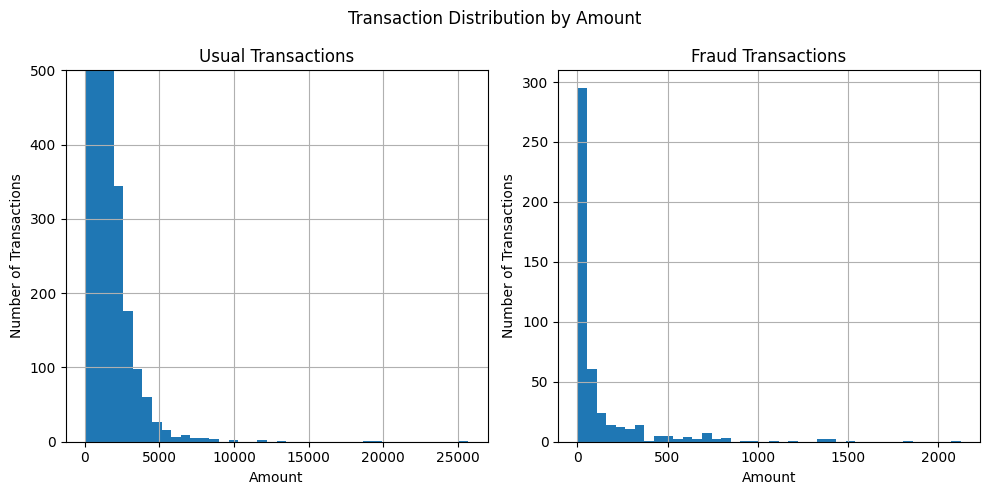

In [10]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
usual['Amount'].hist(bins=40)
plt.title('Usual Transactions')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.ylim((0, 500))

plt.subplot(1,2,2)
fraud['Amount'].hist(bins=40)
plt.title('Fraud Transactions')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')

plt.suptitle('Transaction Distribution by Amount')
plt.tight_layout()
plt.show()

The above histogram reveals that majority of the fraudulent transactions comprise of small amount while only a few proportion of the fraudulent transactions amount to high values.

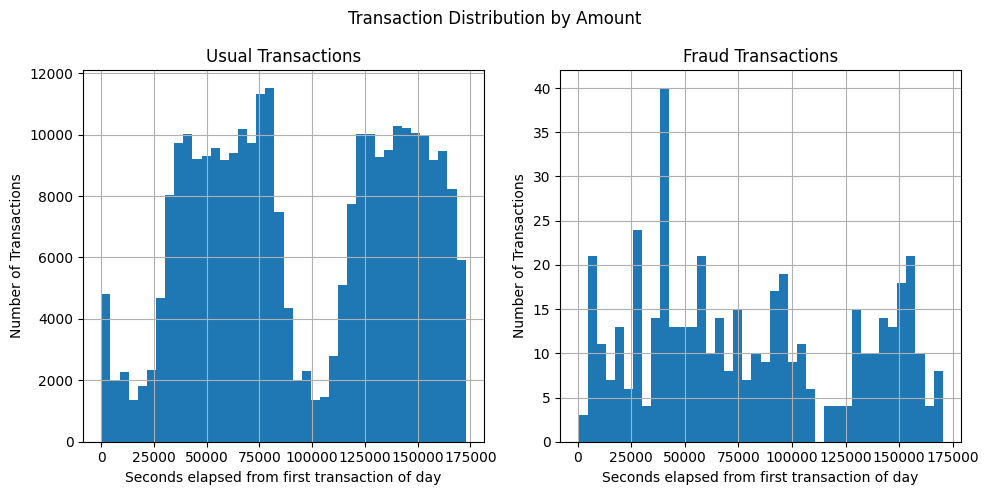

In [11]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
usual['Time'].hist(bins=40)
plt.title('Usual Transactions')
plt.xlabel('Seconds elapsed from first transaction of day')
plt.ylabel('Number of Transactions')

plt.subplot(1,2,2)
fraud['Time'].hist(bins=40)
plt.title('Fraud Transactions')
plt.xlabel('Seconds elapsed from first transaction of day')
plt.ylabel('Number of Transactions')

plt.suptitle('Transaction Distribution by Amount')
plt.tight_layout()
plt.show()

The above histograms don't reveal anything peculiar about the relation between number of fraud transactions and time elapsed since first transaction of the day.

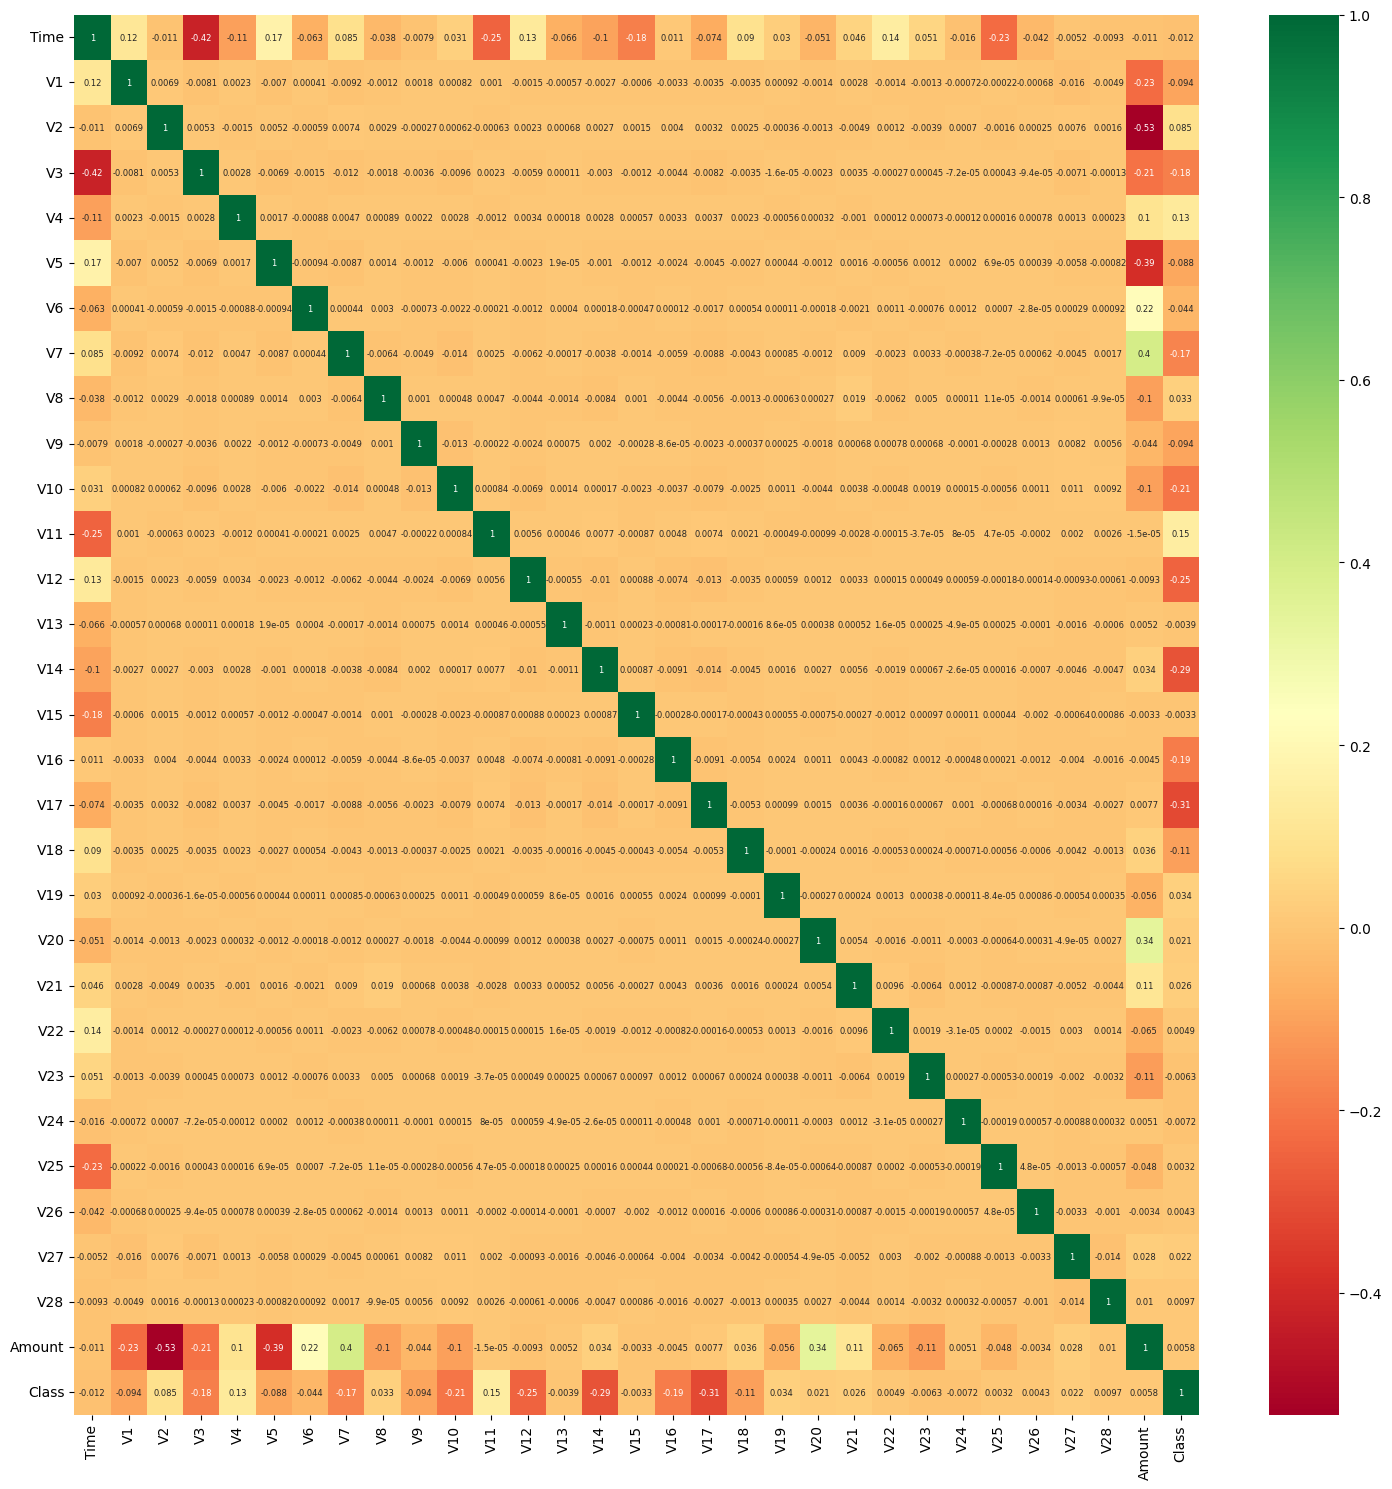

In [12]:
corr_mat = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_mat, annot=True, cmap='RdYlGn', annot_kws={'size':6})

plt.tight_layout()
plt.show()

There's no high correlation between any of the features.

## Modelling

#### Dataset splitting

In [13]:
X = df.iloc[:,:-1]
y = df['Class']

In [14]:
X.shape, y.shape

((283726, 30), (283726,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420, stratify=y)

print(f'Training set size: {X_train.shape[0]} ({len(y_train[y_train == 0])} Normal & {len(y_train[y_train == 1])} Fraud)')
print(f'Test set size: {X_test.shape[0]} ({len(y_test[y_test == 0])} Normal & {len(y_test[y_test == 1])} Fraud)')


Training set size: 226980 (226602 Normal & 378 Fraud)
Test set size: 56746 (56651 Normal & 95 Fraud)


In [74]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)

pca = PCA(2)

X_train_pca = pca.fit_transform(X_train_std)

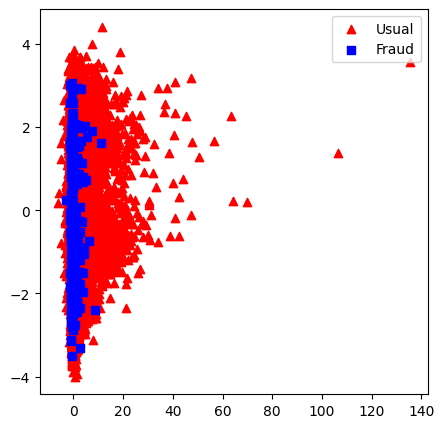

In [75]:
labels = {0: 'Usual', 1: 'Fraud'}

fig = plt.figure(figsize=(5,5))

for l,c,m in zip(range(2), ('red', 'blue'), ('^', 's')):
    plt.scatter(X_train_pca[y_train==l,0], X_train_pca[y_train==l,1], c=c, marker=m, label=labels[l])
plt.legend()

plt.show()

#### Training Models

### Logistic Regression

In [16]:
log_clf = LogisticRegression()

log_clf.fit(X_train, y_train)

/usr/local/bin/.mlvenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Test Set Accuracy: 0.999048391076023
Test Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.71      0.74      0.72        95

    accuracy                           1.00     56746
   macro avg       0.85      0.87      0.86     56746
weighted avg       1.00      1.00      1.00     56746



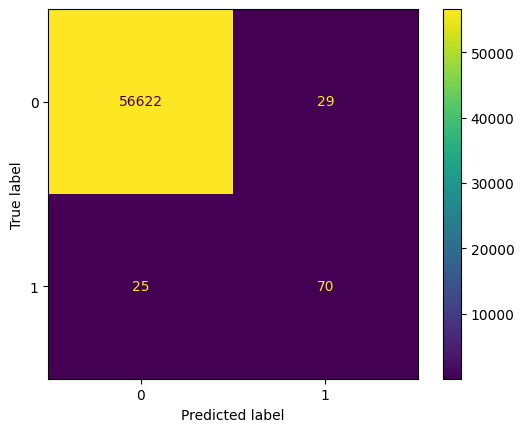

In [21]:
log_clf_y_pred = log_clf.predict(X_test)

log_clf_conf_mat = confusion_matrix(y_test, log_clf_y_pred)
disp = ConfusionMatrixDisplay(log_clf_conf_mat, display_labels=log_clf.classes_)
log_clf_accuracy = accuracy_score(y_test, log_clf_y_pred)
log_clf_report = classification_report(y_test, log_clf_y_pred)

disp.plot()
print(f'Test Set Accuracy: {log_clf_accuracy}')
print(f'Test Set Classification Report: \n{log_clf_report}')

In [16]:
contamination_factor = len(df[df['Class'] == 1]) / len(df)
contamination_factor

0.001667101358352777

### Isolation Forest

In [17]:
isf_clf = IsolationForest(n_estimators=50,
                          max_samples=len(X_train),
                          contamination=contamination_factor,
                          n_jobs=-1,
                          random_state=420)

In [18]:
isf_clf.fit(X_train)

isf_y_pred = isf_clf.predict(X_test)
isf_y_pred[isf_y_pred == 1] = 0
isf_y_pred[isf_y_pred == -1] = 1

isf_clf_accuracy = accuracy_score(y_test, isf_y_pred)
isf_clf_report = classification_report(y_test, isf_y_pred)

print(f'Test Set Accuracy: {isf_clf_accuracy}')
print(f'Test Set Classification Report: \n{isf_clf_report}')

/usr/local/bin/.mlvenv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Test Set Accuracy: 0.9978853135022733
Test Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.37      0.38      0.37        95

    accuracy                           1.00     56746
   macro avg       0.69      0.69      0.69     56746
weighted avg       1.00      1.00      1.00     56746



### Local Outlier Factor

In [21]:
lof_clf = LocalOutlierFactor(contamination=contamination_factor,
                             novelty=True)

In [22]:
lof_clf.fit(X_train)

lof_y_pred = lof_clf.predict(X_test)
lof_y_pred[lof_y_pred == 1] = 0
lof_y_pred[lof_y_pred == -1] = 1

lof_clf_accuracy = accuracy_score(y_test, lof_y_pred)
lof_clf_report = classification_report(y_test, lof_y_pred)

print(f'Test Set Accuracy: {lof_clf_accuracy}')
print(f'Test Set Classification Report: \n{lof_clf_report}')

/usr/local/bin/.mlvenv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test Set Accuracy: 0.9966341239911183
Test Set Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.03      0.03      0.03        95

    accuracy                           1.00     56746
   macro avg       0.51      0.51      0.51     56746
weighted avg       1.00      1.00      1.00     56746



The accuracy of both the Isolation Forest and Local Outlier Factor models is almost same, but the F1-score of the Isolation Forest model outperforms the F1-score of the LOF model and thus we can conclude that the Isolation Forest is the best (also the fastest) choice for anomaly detection in this dataset.